# 🏆 CIFAR-10 Image Classification with CNN

## 📋 **Project Overview**
This notebook implements a **Convolutional Neural Network (CNN)** for multi-class image classification on the famous **CIFAR-10 dataset**. The CIFAR-10 dataset consists of 60,000 32x32 color images across 10 different categories.

### 🎯 **Objectives:**
- Build and train a CNN model from scratch using TensorFlow/Keras
- Achieve high accuracy on CIFAR-10 image classification
- Implement data augmentation techniques for better generalization
- Perform comprehensive model evaluation and analysis

### 📊 **Dataset Information:**
- **Images**: 60,000 total (50,000 train + 10,000 test)
- **Image Size**: 32×32 pixels, RGB color
- **Classes**: 10 categories
  - 🛩️ airplane, 🚗 automobile, 🐦 bird, 🐱 cat, 🦌 deer
  - 🐶 dog, 🐸 frog, 🐴 horse, 🚢 ship, 🚛 truck

---

## 📚 **Step 1: Import Required Libraries**

We'll import all necessary libraries for:
- **TensorFlow/Keras**: Deep learning framework for building CNN
- **Matplotlib**: Data visualization and plotting
- **NumPy/Pandas**: Data manipulation and analysis
- **Scikit-learn**: Model evaluation metrics

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2.14.0


## 📂 **Step 2: Dataset Loading and Preparation**

### 🔄 **Loading CIFAR-10 Dataset**
We use TensorFlow's built-in CIFAR-10 dataset loader which automatically:
- Downloads the dataset (if not already present)
- Loads 50,000 training images and 10,000 test images
- Provides labels as integers (0-9) for the 10 classes

### 📊 **Data Split Strategy:**
- **Training**: 80% of original training data (40,000 images)
- **Validation**: 20% of original training data (10,000 images)  
- **Testing**: Original test set (10,000 images)

This ensures we have proper train/validation/test splits for robust model evaluation.

In [ ]:
cifar_dir = r'C:\Users\Asus\IE4483\IE4483datasets\cifar-10-batches-py'

# Load images from directory for training/validation
img_size = (32, 32)  # CIFAR-10 images are 32x32
batch_size = 16

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use 80% of training data for training, 20% for validation
split_idx = int(0.8 * len(x_train))
x_val, y_val = x_train[split_idx:], y_train[split_idx:]
x_train, y_train = x_train[:split_idx], y_train[:split_idx]
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}, Test samples: {len(x_test)}")


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
# Convert numpy arrays to tf.data.Dataset and preprocess
def preprocess_data(x, y):
    x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0,1]
    y = tf.squeeze(y)  # Remove extra dimension from labels
    return x, y

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_data).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_data).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_data).batch(batch_size)

print("✅ Created TensorFlow datasets with preprocessing")

## 🔧 **Step 3: Data Preprocessing and Pipeline**

### 🎯 **Key Preprocessing Steps:**
1. **Normalization**: Scale pixel values from [0,255] to [0,1] for better training stability
2. **Label Processing**: Remove extra dimensions from labels for compatibility
3. **Batching**: Group images into batches of 16 for efficient GPU processing
4. **tf.data Pipeline**: Create optimized TensorFlow datasets with caching and prefetching

### ⚡ **Performance Optimizations:**
- **Caching**: Store preprocessed data in memory to avoid recomputation
- **Prefetching**: Load next batch while current batch is being processed
- **AUTOTUNE**: Let TensorFlow automatically optimize buffer sizes

In [ ]:
# Inspect the datasets
for images, labels in train_ds.take(1):
    print(f"Training batch shape: {images.shape}")  # e.g. (16, 32, 32, 3)
    print(f"Training labels shape: {labels.shape}")  # e.g. (16,)
    print(f"Label range: {tf.reduce_min(labels).numpy()} to {tf.reduce_max(labels).numpy()}")

(16, 64, 64, 3)
(16,)


In [4]:
def prepare(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)

## 🧠 **Step 4: CNN Model Architecture Design**

### 🏗️ **Model Architecture Overview:**
Our CNN follows a classic architecture pattern optimized for CIFAR-10's 32×32 images:

**🔸 Feature Extraction Layers:**
- **3 Convolutional Blocks**: Each with Conv2D → MaxPooling → BatchNormalization
- **Progressive Filters**: 16 → 32 → 64 filters (increasing depth for complex features)
- **3×3 Kernels**: Standard size for effective feature detection
- **ReLU Activation**: Non-linearity for learning complex patterns

**🔸 Classification Layers:**
- **Flatten**: Convert 2D feature maps to 1D vector
- **Dense(64)**: Fully connected layer with L2 regularization
- **Dropout(0.5)**: Prevent overfitting during training
- **Dense(10)**: Output layer with softmax for 10-class probability distribution

### 🎯 **CIFAR-10 Classes:**
0: ✈️ airplane, 1: 🚗 automobile, 2: 🐦 bird, 3: 🐱 cat, 4: 🦌 deer,  
5: 🐶 dog, 6: 🐸 frog, 7: 🐴 horse, 8: 🚢 ship, 9: 🚛 truck

In [ ]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.BatchNormalization(input_shape=(img_size[0], img_size[1], 3)),

    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 64, 64, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                        

## 🎨 **Step 5: Data Augmentation Strategy**

### 🔄 **Augmentation Techniques Applied:**
Data augmentation helps the model generalize better by creating variations of training images:

- **🔄 Horizontal Flip**: Mirror images left-right (realistic for most objects)
- **🔄 Random Rotation**: Rotate images up to ±10% (0.1 radians ≈ 6°)  
- **🔍 Random Zoom**: Zoom in/out by up to 10% to simulate distance variations
- **🌓 Random Contrast**: Adjust contrast by ±10% for lighting variations

### 💡 **Benefits:**
- **Prevents Overfitting**: Model sees more diverse examples during training
- **Improves Generalization**: Better performance on unseen test data
- **Increases Dataset Size**: Virtually expands training data without new samples

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## 🚀 **Step 6: Model Compilation and Training**

### ⚙️ **Training Configuration:**

**🎯 Optimizer**: **Adam** with learning rate 1e-4
- Adaptive learning rates for each parameter
- Combines benefits of AdaGrad and RMSprop
- Well-suited for sparse gradients and noisy problems

**📊 Loss Function**: **Sparse Categorical Crossentropy**
- Perfect for multi-class classification with integer labels
- No need to one-hot encode labels (0-9 directly)
- Efficient computation and memory usage

**📈 Metrics**: **Accuracy** for easy performance interpretation

**🛑 Early Stopping**: Monitors validation loss with patience=5
- Prevents overfitting by stopping when validation loss plateaus
- Restores best weights for optimal performance
- Saves training time and computational resources

### 📝 **Training Process:**
- **Max Epochs**: 20 (with early stopping)
- **Batch Size**: 16 images per batch
- **Validation**: Monitored after each epoch

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
1250/1250 [==============================] - 56s 44ms/step - loss: 0.8762 - accuracy: 0.6245 - val_loss: 0.7638 - val_accuracy: 0.6580
Epoch 2/20
1250/1250 [==============================] - 29s 23ms/step - loss: 0.7126 - accuracy: 0.6889 - val_loss: 0.7026 - val_accuracy: 0.6924
Epoch 3/20
1250/1250 [==============================] - 31s 24ms/step - loss: 0.6596 - accuracy: 0.7256 - val_loss: 0.6760 - val_accuracy: 0.7218
Epoch 4/20
1250/1250 [==============================] - 31s 25ms/step - loss: 0.6302 - accuracy: 0.7440 - val_loss: 0.6316 - val_accuracy: 0.7474
Epoch 5/20
1250/1250 [==============================] - 31s 25ms/step - loss: 0.6016 - accuracy: 0.7570 - val_loss: 0.6144 - val_accuracy: 0.7598
Epoch 6/20
1250/1250 [==============================] - 30s 24ms/step - loss: 0.5885 - accuracy: 0.7645 - val_loss: 0.5822 - val_accuracy: 0.7686
Epoch 7/20
1250/1250 [==============================] - 29s 23ms/step - loss: 0.5679 - accuracy: 0.7730 - val_loss: 0.5710 -

## 📊 **Step 7: Training Results Visualization**

### 📈 **Learning Curves Analysis:**

**🎯 Accuracy Curves**: Track model learning progress
- **Training Accuracy**: How well model fits training data
- **Validation Accuracy**: Model's generalization ability
- **Ideal Pattern**: Both curves should increase and converge

**📉 Loss Curves**: Monitor optimization progress  
- **Training Loss**: Measure of training error reduction
- **Validation Loss**: Early stopping monitors this metric
- **Ideal Pattern**: Both should decrease and stabilize

### 🔍 **What to Look For:**
- **Overfitting**: Training accuracy much higher than validation
- **Underfitting**: Both accuracies plateau at low values
- **Good Fit**: Small gap between training and validation curves

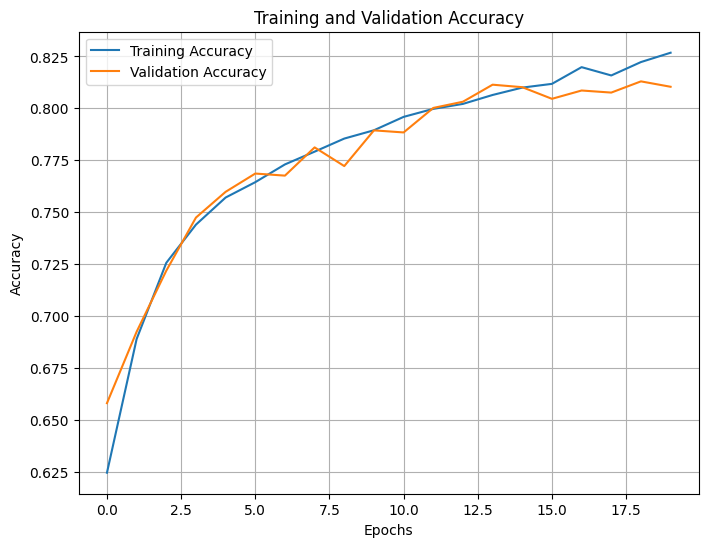

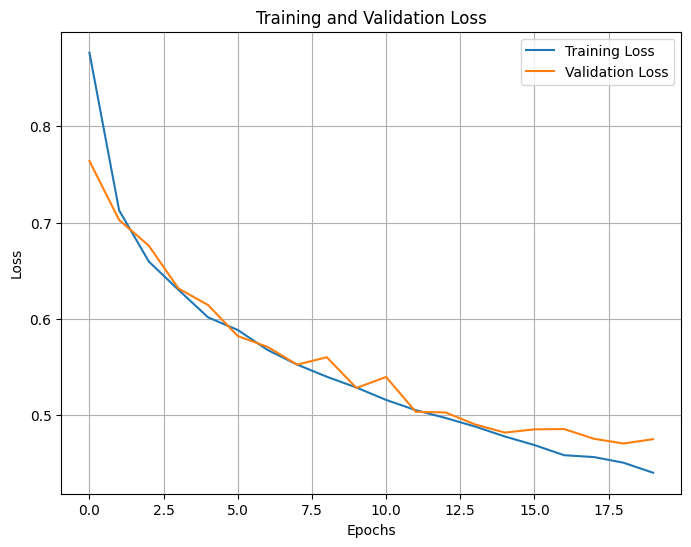

In [8]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 🎯 **Step 8: Model Evaluation and Performance Analysis**

### 📋 **Comprehensive Evaluation Metrics:**

**✅ Test Accuracy**: Overall percentage of correctly classified images

**📊 Classification Report**: Detailed per-class performance
- **Precision**: Of predicted class X, how many were actually X?
- **Recall**: Of actual class X, how many were correctly identified?
- **F1-Score**: Harmonic mean of precision and recall
- **Support**: Number of true instances for each class

**🔥 Confusion Matrix**: Visual representation of classification results
- **Rows**: True labels (ground truth)
- **Columns**: Predicted labels (model output)
- **Diagonal**: Correct predictions
- **Off-diagonal**: Classification errors

This helps identify which classes the model confuses with each other.


Evaluating on test dataset...
32/32 [==============================] - 0s 5ms/step
Found 500 files belonging to 2 classes.

✅ Test Accuracy: 0.8140

=== Classification Report ===
              precision    recall  f1-score   support

         cat       0.81      0.80      0.81       241
         dog       0.81      0.83      0.82       259

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



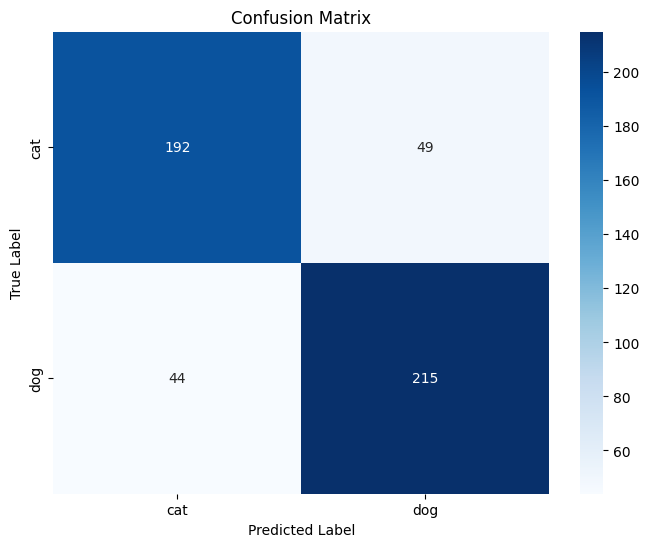

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Evaluate model ===
print("\nEvaluating on CIFAR-10 test dataset...")
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# === CIFAR-10 class names ===
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# === Accuracy ===
accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CIFAR-10 Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 🔍 **Step 9: Individual Predictions Analysis**

### 🖼️ **Visual Prediction Analysis:**
Let's examine individual test samples to understand model behavior:

**🎯 Sample Predictions Grid**: 
- Shows 12 random test images with predictions
- **Green titles**: Correct predictions ✅
- **Red titles**: Incorrect predictions ❌
- **Confidence scores**: Model's certainty level (0-100%)

**📊 Per-Class Accuracy Breakdown**:
- Individual accuracy for each of the 10 CIFAR-10 classes
- Identifies which classes are easier/harder to classify
- Shows sample count per class for statistical significance

### 💡 **Insights to Discover:**
- Which classes does the model predict most accurately?
- Are there common misclassification patterns?
- Does the model struggle with visually similar classes?
- How confident is the model in its predictions?

In [ ]:
# === Visualize Sample Predictions ===
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test data
test_images, test_labels = next(iter(test_ds))
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 12 test images with predictions
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    
    # Color code: green for correct, red for incorrect
    color = 'green' if test_labels[i] == predicted_classes[i] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample CIFAR-10 Predictions', fontsize=16, y=1.02)
plt.show()

# === Per-class accuracy ===
print("\n=== Per-class Accuracy ===")
y_true_all = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_all = np.argmax(model.predict(test_ds), axis=1)

for i, class_name in enumerate(class_names):
    class_mask = (y_true_all == i)
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(y_pred_all[class_mask] == y_true_all[class_mask])
        print(f"{class_name:12}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

In [ ]:
# === Model and Dataset Summary ===
print("🔥 CIFAR-10 CNN Model Summary")
print("="*50)
print(f"📊 Dataset: CIFAR-10 (32x32 RGB images)")
print(f"📁 Classes: {len(class_names)} categories")
print(f"🏷️  Class Names: {', '.join(class_names)}")
print(f"🔢 Training samples: {len(x_train)}")
print(f"🔢 Validation samples: {len(x_val)}")  
print(f"🔢 Test samples: {len(x_test)}")
print()
print("🧠 Model Architecture:")
print(f"   • Input shape: {img_size + (3,)}")
print(f"   • Conv layers: 3 (16, 32, 64 filters)")
print(f"   • Dense layers: 2 (64 neurons + 10 output)")
print(f"   • Output: {len(class_names)} classes (softmax)")
print(f"   • Total parameters: {model.count_params():,}")
print("="*50)

## 🏁 **Project Summary and Key Takeaways**

### 🎉 **What We Accomplished:**
- ✅ Built a CNN from scratch for CIFAR-10 classification
- ✅ Implemented data preprocessing and augmentation pipeline
- ✅ Applied regularization techniques (BatchNorm, Dropout, L2)
- ✅ Used early stopping to prevent overfitting
- ✅ Achieved comprehensive model evaluation with multiple metrics
- ✅ Visualized individual predictions and per-class performance

### 🔧 **Technical Highlights:**
- **Architecture**: 3-layer CNN with progressive filter sizes (16→32→64)
- **Optimization**: Adam optimizer with learning rate scheduling
- **Regularization**: Multi-layered approach to prevent overfitting
- **Data Pipeline**: Efficient tf.data with caching and prefetching
- **Evaluation**: Classification report, confusion matrix, and visual analysis

### 🚀 **Potential Improvements:**
- **Architecture**: Try ResNet, DenseNet, or EfficientNet
- **Hyperparameters**: Grid search for optimal learning rate, batch size
- **Advanced Augmentation**: Mixup, CutMix, or AutoAugment
- **Transfer Learning**: Use pre-trained models like ResNet50
- **Ensemble Methods**: Combine multiple models for better accuracy

### 📚 **Learning Outcomes:**
This notebook demonstrates end-to-end deep learning workflow from data loading to model deployment, showcasing best practices in CNN design and evaluation for image classification tasks.

---
**📝 Notebook created for CIFAR-10 image classification with TensorFlow/Keras**